# RNN

## Lib and Data Loading

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
import torchmetrics

import os
from glob import glob
from pathlib import Path
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

# override all pandas display limits
pd.options.display.max_columns = None
pd.options.display.max_rows = None



In [2]:
# load parquet files
data_path = Path("../../../data")
notebooks_path = Path(os.getcwd())
data_dir = {}

##unsafe
# for file_path in list((notebooks_path / data_path).glob("*.parquet")):
#     print(f"Reading {file_path}")
#     # retrieve the name of the file without the extension for all OS
#     data = pd.read_parquet(file_path)
#     # if "Time" in df.columns:
#     #     df["Time"] = pd.to_datetime(df["Time"])
#     data_dir[str(file_path).replace("\\", "/").split("/")[-1].split(".")[0].replace("-", "_")] = data

for file_path in (notebooks_path / data_path).glob("set*.parquet"):
    var_name = file_path.stem.replace("-", "_")
    globals()[var_name] = pd.read_parquet(file_path)
    print(f"Reading {file_path} -> {var_name}")


ID_vars = ["PatientID", "Time", "RecordID"] # TODO 
# stationary variables
stationary_vars = ["Age", "Gender", "Height"] #, "ICUType"]
# dynamic variables
dynamic_vars = set_a.columns.difference(stationary_vars + ID_vars + ["In-hospital_death"]).tolist()

feature_cols = dynamic_vars + stationary_vars




Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/../../../data/set-a-filled.parquet -> set_a_filled
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/../../../data/set-b.parquet -> set_b
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/../../../data/set-a.parquet -> set_a
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/../../../data/set-c-filled.parquet -> set_c_filled
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/../../../data/set-c.parquet -> set_c
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/../../../data/set-b-filled.parquet -> set_b_filled


## Preprocess Data Shape

In [3]:
from sklearn.model_selection import KFold

class TimeSeriesDataModule(pl.LightningDataModule):
    def __init__(
        self,
        feature_cols,
        batch_size=32,
        k_folds=None,  # set this to an int (e.g., 5) to activate k-fold
        fold_index=0    # index of current fold
    ):
        super().__init__()
        self.feature_cols = feature_cols
        self.batch_size = batch_size
        self.k_folds = k_folds
        self.fold_index = fold_index



    def preprocess_parquet_for_lstm(self, key, scaler=None, fit_scaler=False):
        labelname = 'In-hospital_death'
        

        # if isinstance(key, list):
        #     df = globals()[f"set_{key}_filled"].copy()
        # else: 
        df = globals()[f"set_{key}_filled"].copy()
            
    
        # Sort and fill NaNs
        df = df.sort_values(["RecordID", "Time"])
        df[self.feature_cols] = df[self.feature_cols].fillna(0)
    
        # Replace -1 with 0 in binary categorical feature
        if "MechVent" in df.columns:
            df["MechVent"] = df["MechVent"].replace(-1, 0)
    
        # One-hot encode Gender, drop last column to avoid multicollinearity
        if "Gender" in df.columns:
            gender_dummies = pd.get_dummies(df["Gender"], prefix="Gender", dtype=float)
            gender_dummies = gender_dummies.iloc[:, :-1]  # drop last dummy column
            df = df.drop(columns=["Gender"])
            df = pd.concat([df, gender_dummies], axis=1)
    
        # Update feature columns after dummy encoding
        current_feature_cols = [col for col in df.columns if col in self.feature_cols or col.startswith("Gender_")]
    
        # Extract numerical columns for scaling
        numerical = [f for f in current_feature_cols if f not in ["MechVent", labelname] and not f.startswith("Gender_")]
    
        # Fit or reuse scaler
        if fit_scaler or scaler is None:
            scaler = StandardScaler()
            scaler.fit(df[numerical])
    
        # Apply scaling
        df[numerical] = scaler.transform(df[numerical])
    
        # Group by RecordID
        X, y = [], []
        for pid, group in df.groupby("RecordID"):
            group = group.sort_values("Time")
            X.append(group[current_feature_cols].values)
            label = group[labelname].iloc[0]
            # if label not in [0, 1]:
            #     raise ValueError(f"Unexpected label {label} for patient {pid}. Expected binary labels only.")
            y.append(int(label))

    
        X_tensor = torch.tensor(np.stack(X)).float()
        y_tensor = torch.tensor(y).float()
    
        return X_tensor, y_tensor, scaler
        



    def setup(self, stage=None):
        # # Load training and validation sets and stack them
        # X_trainval_a, y_trainval_a, fitted_scaler = self.preprocess_parquet_for_lstm("a", fit_scaler=True)
        # X_trainval_b, y_trainval_b, _ = self.preprocess_parquet_for_lstm("b", scaler=fitted_scaler)

        # # Stack A and B
        # X_trainval = torch.cat([X_trainval_a, X_trainval_b], dim=0)
        # y_trainval = torch.cat([y_trainval_a, y_trainval_b], dim=0)

        # if self.k_folds:
        #     kf = KFold(n_splits=self.k_folds, shuffle=True, random_state=42)
        #     indices = list(kf.split(X_trainval))

        #     train_idx, val_idx = indices[self.fold_index]
        #     self.X_train, self.y_train = X_trainval[train_idx], y_trainval[train_idx]
        #     self.X_val, self.y_val     = X_trainval[val_idx], y_trainval[val_idx]
        # else:
        #     self.X_train, self.y_train = X_trainval_a, y_trainval_a
        #     self.X_val, self.y_val     = X_trainval_b, y_trainval_b

        # self.X_test, self.y_test, _ = self.preprocess_parquet_for_lstm("c", scaler=fitted_scaler)

        # self.train_dataset = TensorDataset(self.X_train, self.y_train)
        # self.val_dataset   = TensorDataset(self.X_val, self.y_val)
        # self.test_dataset  = TensorDataset(self.X_test, self.y_test)
        self.X_train, self.y_train, fitted_scaler = self.preprocess_parquet_for_lstm("a", fit_scaler = True)
        self.X_val, self.y_val , _    = self.preprocess_parquet_for_lstm("b", scaler = fitted_scaler)
        self.X_test, self.y_test , _  = self.preprocess_parquet_for_lstm("c", scaler = fitted_scaler)

        self.train_dataset = TensorDataset(self.X_train, self.y_train)
        self.val_dataset   = TensorDataset(self.X_val, self.y_val)
        self.test_dataset  = TensorDataset(self.X_test, self.y_test)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)



## LSTM Model Class

In [27]:
class LSTMClassifier(pl.LightningModule):
    def __init__(self, input_size, hidden_size=64, num_layers=1, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Linear(hidden_size, 1)
        self.loss_fn = nn.BCEWithLogitsLoss()

        # Store test outputs manually
        self.test_probs = []
        self.test_targets = []

        # Prediction threshold
        self.prediction_threshold = 0.5
        self.clear_after_testing = False

    def forward(self, x):
        # Run input through the LSTM
        _, (hidden_state, _) = self.lstm(x)  # lstm_output, (hidden_state, cell_state)

        # Take the last layer's hidden state (for stacked LSTM)
        last_hidden = hidden_state[-1]  # shape: (batch_size, hidden_dim)

        # Pass through the classification head
        logits = self.classifier(last_hidden)

        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze(1)
        loss = self.loss_fn(logits, y.float())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze(1)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits) > 0.5
        acc = (preds.int() == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss
        

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze(1)
        probs = torch.sigmoid(logits)
        # print(torch.unique(log
        loss = self.loss_fn(logits, y.float())

        self.log("test_loss", loss)

        # Store results for epoch-end metrics
        self.test_probs.append(probs.detach().cpu())
        self.test_targets.append(y.detach().cpu())

        return loss  # or None — you’re not using batch outputs anymore

    def on_test_epoch_end(self):
            probs = torch.cat(self.test_probs).cpu()
            targets = torch.cat(self.test_targets).cpu()
            preds = (probs > 0.5).int()
            
            # Convert both to int numpy arrays
            targets_np = targets.int().numpy()
            preds_np = preds.numpy()

            if self.clear_after_testing: 
                self.test_probs.clear()
                self.test_targets.clear()
    
            # --- Confusion Matrix ---
            cm = confusion_matrix(targets_np, preds_np)
            disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp_cm.plot(cmap='Blues')
            plt.title("Confusion Matrix")
            plt.show()
    
            # --- ROC Curve ---
            auc = roc_auc_score(targets_np, probs.numpy())
            RocCurveDisplay.from_predictions(targets, probs)
            plt.title(f"ROC Curve (AuROC = {auc:.3f})")
            plt.show()
    
            # --- Precision-Recall Curve ---
            auprc = average_precision_score(targets_np, probs.numpy())
            PrecisionRecallDisplay.from_predictions(targets, probs)
            plt.title(f"Precision-Recall Curve (AuPRC = {auprc:.3f})")
            plt.show()
    
            # --- Metrics ---
            acc = (preds == targets).float().mean()
            self.log("test_acc", acc)
            self.log("test_auroc", auc)
            self.log("test_auprc", auprc)
    
            print(f"\nTest Accuracy : {acc:.4f}")
            print(f"Test AuROC    : {auc:.4f}")
            print(f"Test AuPRC    : {auprc:.4f}")


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def tune_threshold_min_fnr(self):
        """
        Find the classification threshold that minimizes the False Negative Rate (FNR)
        and store it in self.prediction_threshold.
    
        Returns:
            best_thresh (float): Threshold with the lowest FNR
            best_fnr (float): Lowest observed FNR
            thresholds (np.ndarray): Array of tested thresholds
            fnrs (List[float]): FNRs corresponding to each threshold
        """
    
        assert hasattr(self, "test_probs") and hasattr(self, "test_targets"), \
            "test_probs and test_targets must be defined (run test first)."
    
        probs = torch.cat(self.test_probs).cpu().numpy()
        targets = torch.cat(self.test_targets).cpu().numpy()
    
        thresholds = np.linspace(0, 1, 100)
        best_thresh = 0.5
        best_fnr = 1.0
        fnrs = []
    
        for t in tqdm(thresholds):
            preds = (probs >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 1.0
            fnrs.append(fnr)
    
            if fnr < best_fnr:
                best_fnr = fnr
                best_thresh = t
    
        self.prediction_threshold = best_thresh
    
        return best_thresh, best_fnr, thresholds, fnrs

class BiLSTMClassifier(LSTMClassifier):
    def __init__(self, input_size, hidden_size=64, num_layers=1, lr=1e-3):
        super().__init__(input_size, hidden_size, num_layers, lr)

        # Redefine LSTM as bidirectional
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Since BiLSTM doubles hidden size, update classifier input
        self.classifier = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        _, (hidden_state, _) = self.lstm(x)  # hidden_state: (num_layers*2, batch, hidden)

        # Get last layer's forward and backward hidden states
        forward = hidden_state[-2]
        backward = hidden_state[-1]

        # Concatenate both directions
        last_hidden = torch.cat((forward, backward), dim=1)  # (batch, hidden*2)

        return self.classifier(last_hidden)


In [28]:
def get_callbacks(model_name):
    return [
        EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min'),
        LearningRateMonitor(logging_interval='epoch'),
        ModelCheckpoint(
            monitor='val_loss',
            mode='min',
            save_top_k=1,
            verbose=True,
            filename=f'{model_name}-best-checkpoint',
            dirpath=os.path.join("lightning_logs", model_name, "checkpoints")
        )
    ]
def train_model(ModelClass, model_name, datamodule, input_size, k_folds=None, n_layers=5, h_size=64, return_model=False):
    if k_folds:
        print(f"Training {model_name} with {k_folds}-fold cross-validation...\n")
        trained_models = []

        for fold in range(k_folds):
            print(f"\n=== Fold {fold+1}/{k_folds} ===")

            # Re-initialize datamodule with current fold
            fold_dm = TimeSeriesDataModule(
                feature_cols=datamodule.feature_cols,
                batch_size=datamodule.batch_size,
                k_folds=k_folds,
                fold_index=fold
            )
            fold_dm.setup()

            model = ModelClass(input_size=input_size, hidden_size=h_size, num_layers=n_layers)
            fold_name = f"{model_name}-fold{fold}"

            trainer = pl.Trainer(
                max_epochs=20,
                callbacks=get_callbacks(fold_name),
                log_every_n_steps=10,
                accelerator="auto",
                devices="auto",
                default_root_dir=os.path.join("lightning_logs", fold_name)
            )

            trainer.fit(model, datamodule=fold_dm)

            if return_model:
                trained_models.append(model)

            # Optional test after each fold
            test_model(ModelClass, fold_name, fold_dm, model=model)

        if return_model:
            return trained_models

    else:
        print(f"Training {model_name} without cross-validation...")
        model = ModelClass(input_size=input_size, hidden_size=h_size, num_layers=n_layers)

        trainer = pl.Trainer(
            max_epochs=20,
            callbacks=get_callbacks(model_name),
            log_every_n_steps=10,
            accelerator="auto",
            devices="auto",
            default_root_dir=os.path.join("lightning_logs", model_name)
        )

        trainer.fit(model, datamodule=datamodule)

        if return_model:
            return model


def test_model(ModelClass, model_name, datamodule, model=None):
    print(f"Testing {model_name}...")

    if model is None:
        # Load best checkpoint if model is not provided
        ckpt_dir = os.path.join("lightning_logs", model_name, "checkpoints")
        ckpt_files = glob(os.path.join(ckpt_dir, "*.ckpt"))
        best_ckpt_path = ckpt_files[0] if ckpt_files else None
        print(f"Checkpoint files found: {ckpt_files}")

        if best_ckpt_path:
            print(f"Best checkpoint: {best_ckpt_path}")
            model = ModelClass.load_from_checkpoint(best_ckpt_path)
        else:
            print(f"No checkpoint found for model '{model_name}'. Skipping test.")
            return

    trainer = pl.Trainer(accelerator="auto", devices="auto")
    trainer.test(model, datamodule=datamodule)


In [38]:
# Setup
k_folds = None
h_size = 64
n_layers = 1
input_size = len(feature_cols) + 1
datamodule = TimeSeriesDataModule(feature_cols=feature_cols, batch_size=64, k_folds = k_folds)

In [39]:
# Train both models
# For single train/val split:
# train_model(LSTMClassifier, "lstm", datamodule, input_size)

# For 5-fold cross-validation:
lstm_model = train_model(LSTMClassifier, "lstm", datamodule, input_size, k_folds=k_folds, h_size = h_size, n_layers = n_layers, return_model=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training lstm without cross-validation...


/cluster/courses/ml4h/project1env/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/lstm/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | lstm       | LSTM              | 27.6 K | train
1 | classifier | Linear            | 65     | train
2 | loss_fn    | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------
27.7 K    Trainable params
0         Non-trainable params
27.7 K    Total params
0.111     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.332
Epoch 0, global step 63: 'val_loss' reached 0.33202 (best 0.33202), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/lstm/checkpoints/lstm-best-checkpoint-v8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.309
Epoch 1, global step 126: 'val_loss' reached 0.30917 (best 0.30917), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/lstm/checkpoints/lstm-best-checkpoint-v8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 189: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.303
Epoch 3, global step 252: 'val_loss' reached 0.30313 (best 0.30313), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/lstm/checkpoints/lstm-best-checkpoint-v8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 315: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 378: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 441: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 504: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 567: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 630: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 693: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 756: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 819: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.303. Signaling Trainer to stop.
Epoch 13, global step 882: 'val_loss' was not in top 1


In [36]:
bilstm_model = train_model(BiLSTMClassifier, "bilstm", datamodule, input_size, k_folds = k_folds, return_model=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training bilstm without cross-validation...


/cluster/courses/ml4h/project1env/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/bilstm/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | lstm       | LSTM              | 452 K  | train
1 | classifier | Linear            | 129    | train
2 | loss_fn    | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------
452 K     Trainable params
0         Non-trainable params
452 K     Total params
1.811     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.324
Epoch 0, global step 63: 'val_loss' reached 0.32362 (best 0.32362), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/bilstm/checkpoints/bilstm-best-checkpoint-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.310
Epoch 1, global step 126: 'val_loss' reached 0.31011 (best 0.31011), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/bilstm/checkpoints/bilstm-best-checkpoint-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 189: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 252: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 315: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 378: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 441: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 504: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 567: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 630: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 693: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.310. Signaling Trainer to stop.
Epoch 11, global step 756: 'val_loss' was not in top 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing lstm...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

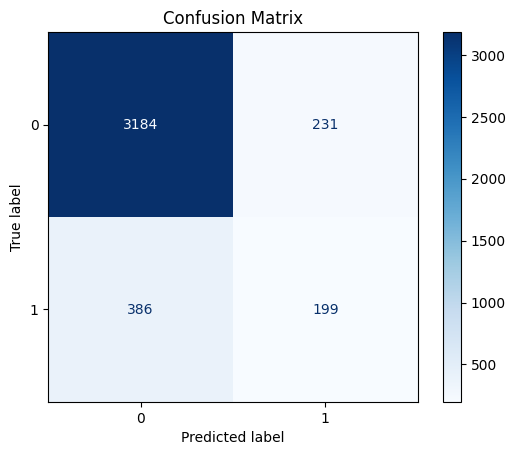

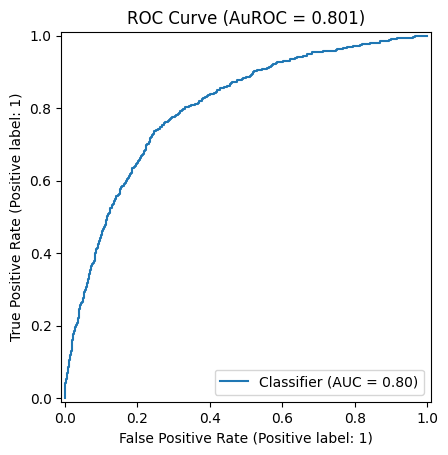

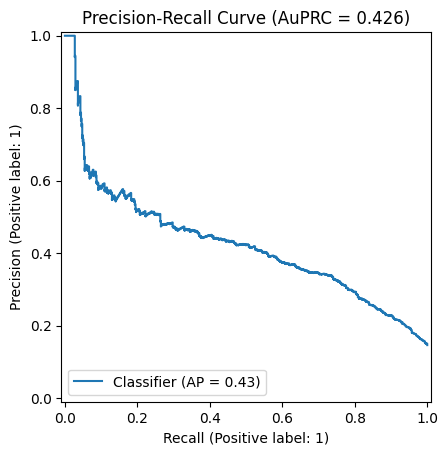


Test Accuracy : 0.8457
Test AuROC    : 0.8009
Test AuPRC    : 0.4256


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8457499742507935     │
│        test_auprc         │    0.42559880018234253    │
│        test_auroc         │    0.8009005188941956     │
│         test_loss         │    0.4331190288066864     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing bilstm...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

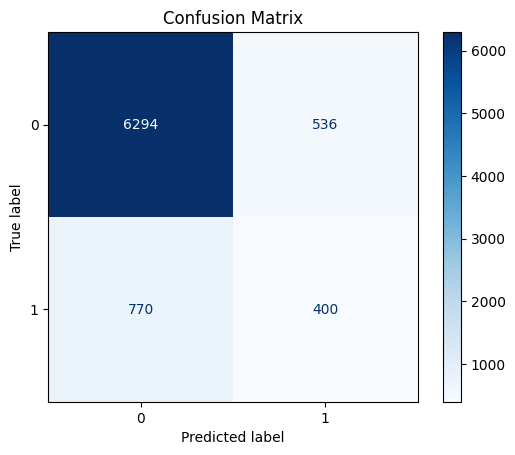

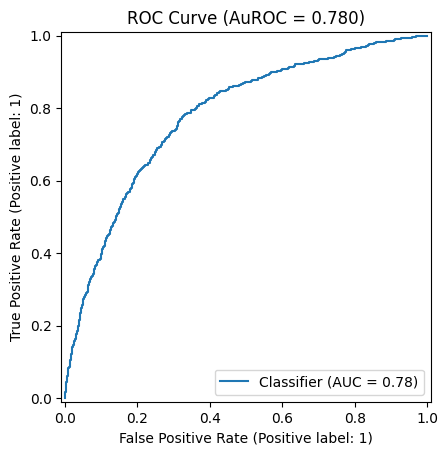

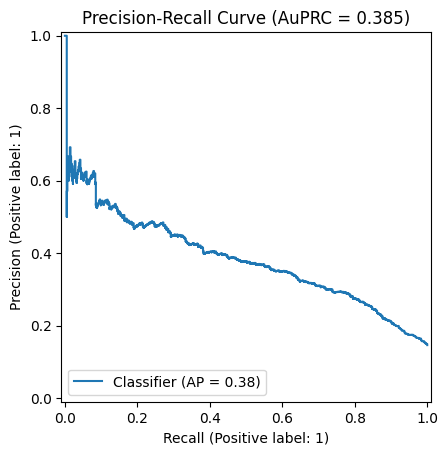


Test Accuracy : 0.8367
Test AuROC    : 0.7801
Test AuPRC    : 0.3848


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8367499709129333     │
│        test_auprc         │    0.38475915789604187    │
│        test_auroc         │    0.7800948619842529     │
│         test_loss         │     0.666806697845459     │
└───────────────────────────┴───────────────────────────┘

In [40]:
# Test both models
test_model(LSTMClassifier, "lstm", datamodule, model = lstm_model)
test_model(BiLSTMClassifier, "bilstm", datamodule, model = bilstm_model)

## Optimize decision Threshold

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Minimize FNR at Threshold')

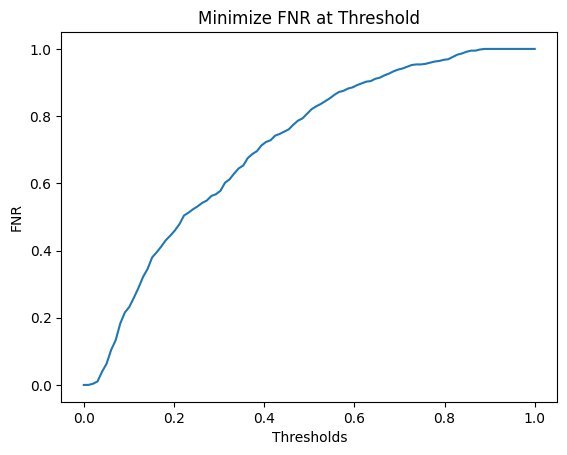

In [11]:
# idea: minimize threshold
_, _, thresholds, fnrs = model.tune_threshold_min_fnr()
plt.plot(thresholds, fnrs)
plt.xlabel("Thresholds")
plt.ylabel("FNR")
plt.title("Minimize FNR at Threshold")
# outcome: to simplistic approach, converges to 0

In [20]:
# model.prediction_threshold = 0.65
# trainer.test(model, datamodule = datamodule)